# Interpretacion Bayesiana de la Estadistica

##Diagnosticos medicos:

En estadistica Bayesiana, las observaciones se usan para inferir la probabilidad de que una hipotesis sea cierta. Se utiliza en la ciencia de decisiones, simulacion de la percepcion y reconocimiento de patrones.

Como ejemplo, sabemos que una enfermedad causa inflamacion en el cuello el 50% de los casos. A priori, la probabilidad de tener esta enfermedad es de 1 entre 50000 y de que cualquier paciente tenga inflamaciones en el cuello es de 1 entre 20. Siendo E la proposicion de que el paciente tenga la enfermedad y C que tenga el cuello inflamado:

In [ ]:
P_E_C = 0.5
P_E = 1/50000
P_C = 1/20
P_C_E = (P_E_C * P_E)/P_C 
print(P_C_E)
print(1/P_C_E)

0.0002
5000.0


Solo un paciente entre 5000 (1/P_C_E) tendria la enfermedad dado el sintoma de cuello inflamado.

##Cubos de Canicas

Tenemos dos cubos, el cubo A y el cubo B. En el cubo A hay 30 canicas azules y 10 canicas amarillas. En el cubo B hay 20 canicas azules y 20 canicas amarillas. Si nos dan una canica cualquiera, ¿de que cubo a venido?.

¿Y si la canica que nos han dado es azul?

La hipotesis, sin informacion previa es:

In [2]:
hipotesis = 'Cubo A', 'Cubo B'
probabilidades = 1/2, 1/2

Por lo tanto, la probabilidad prior se puede escribir, en una serie indexada, como:

In [3]:
import pandas as pd
prior = pd.Series(probabilidades, hipotesis)
print(prior)

Cubo A    0.5
Cubo B    0.5
dtype: float64


Sabemos las probabilidades condicionadas de que la canica sea azul o amarilla dependiendo del cubo que usamos:

In [4]:
probabilidad = 3/4, 1/2

La probabilidad a posteriori es por lo tanto:

In [5]:
post= prior * probabilidad
print(post)

Cubo A    0.375
Cubo B    0.250
dtype: float64


Podemos normalizar la probabilidad a posteriori:

In [6]:
prob_azul = post.sum()
prob_azul

0.625

In [7]:
post_norm = post/prob_azul
post_norm

Cubo A    0.6
Cubo B    0.4
dtype: float64

¿Cual seria la probabilidad si la canica es amarilla?

Respuesta:

# Optimizacion Bayesiana

El objetivo es poder predecir puntos en una funcion, sin conocer la funcion y a traves de ejemplos ruidosos extraidos de la proximidad de la funcion. Ya que los experimentos pueden ser costosos de realizar (realizar las pruebas de medicinas, o perforar pozos para encontrar agua) debemos minimizar el numero de intentos a realizar.

El metodo que vamos a utilizar es una regresion Gausiana o metodo de Wiener–Kolmogorov, tambien conocido como "kriging" por Daniel C. Krig, que aplico la tecnica a la mineria de oro.

Adaptado de: https://nbviewer.org/github/krasserm/bayesian-machine-learning/tree/dev/bayesian-optimization/

Importamos las utilidades extras:

In [ ]:
try:
    import google.colab
    # Archivos adicionales desde Github:
    !wget https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/dev/bayesian-optimization/bayesian_optimization_util.py
    # Dependencias adicionales:
    !pip install scikit-optimize==0.5.2
    !pip install GPy==1.9.8
    !pip install GPyOpt==1.2.1
    !pip install xgboost==0.90
except:
    pass

--2022-02-19 04:23:45--  https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/dev/bayesian-optimization/bayesian_optimization_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1536 (1.5K) [text/plain]
Saving to: ‘bayesian_optimization_util.py’

bayesian_optimizati 100%[===================>]   1.50K  --.-KB/s    in 0s      

2022-02-19 04:23:46 (16.4 MB/s) - ‘bayesian_optimization_util.py’ saved [1536/1536]

     |████████████████████████████████| 74 kB 1.6 MB/s 
     |████████████████████████████████| 989 kB 2.7 MB/s 
     |████████████████████████████████| 71 kB 7.4 MB/s 
  Created wheel for GPy: filename=GPy-1.9.8-cp37-cp37m-linux_x86_64.whl size=2619392 sha256=dc52887c21fdff48a0332943dbb37989220d839377bf30f7e5e3e22b7fb09194
  Stored 

Definimos una funcion, en sus vertientes ruidosas y no ruidosas:

In [ ]:
import numpy as np
%matplotlib inline

limites = np.array([[-3.0, 3.0]])
ruido = 0.2

def f(X, ruido=ruido):
    return -np.sin(3*X) - X**2 + 0.7*X + ruido * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

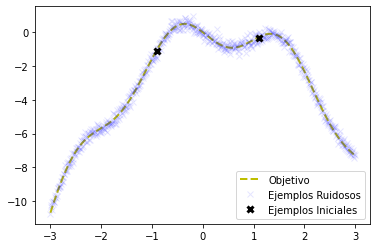

In [ ]:
import matplotlib.pyplot as plt

# Cuadricula densa de numeros dentro de los limites:
X = np.arange(limites[:, 0], limites[:, 1], 0.01).reshape(-1, 1)

# La funcion sin ruido:
Y = f(X, ruido=0)

# Funcion objetivo con y sin ruido: 
plt.plot(X, Y, 'y--', lw=2, label='Objetivo')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Ejemplos Ruidosos')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Ejemplos Iniciales')
plt.legend();

Generamos una funcion para obtener la mejora esperada por inferencia estadistica:

In [ ]:
from scipy.stats import norm

def mejora_esperada(X, X_ejemplo, Y_ejemplo, gpr, xi=0.01):

    #gpr: un GaussianProcessRegressor entrenado con los ejemplos:  
    mu, sigma = gpr.predict(X, return_std=True)
    mu_ejemplo= gpr.predict(X_ejemplo)

    sigma = sigma.reshape(-1, 1)
    mu_ejemplo_opt = np.max(mu_ejemplo)

    with np.errstate(divide='warn'):
        imp = mu - mu_ejemplo_opt - xi
        Z = imp / sigma
        mejora = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        mejora[sigma == 0.0] = 0.0

    return mejora

La documentacion para el regresor gausiano esta aqui: https://scikit-learn.org/stable/modules/gaussian_process.html

Generamos una funcion para proponer una nueva localizacion para extraer un ejemplo:

In [ ]:
from scipy.optimize import minimize

def proponer_localizacion(adquisicion,
                          X_ejemplo, Y_ejemplo, gpr, limites, reinicios=25):

    dim = X_ejemplo.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # El objetivo de minimizar es la inversa de la adquisicion:
        return -adquisicion(X.reshape(-1, dim), X_ejemplo, Y_ejemplo, gpr)
    
    # Buscar el mejor optimo desde un numero, reinicios, de puntos aleatorios:
    for x0 in np.random.uniform(limites[:, 0], limites[:, 1],
                                size=(reinicios, dim)):
        res = minimize(min_obj, x0=x0, bounds=limites, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

Generamos un regresor con nucleo Matern y observamos el ajuste durante un numero de iteraciones:

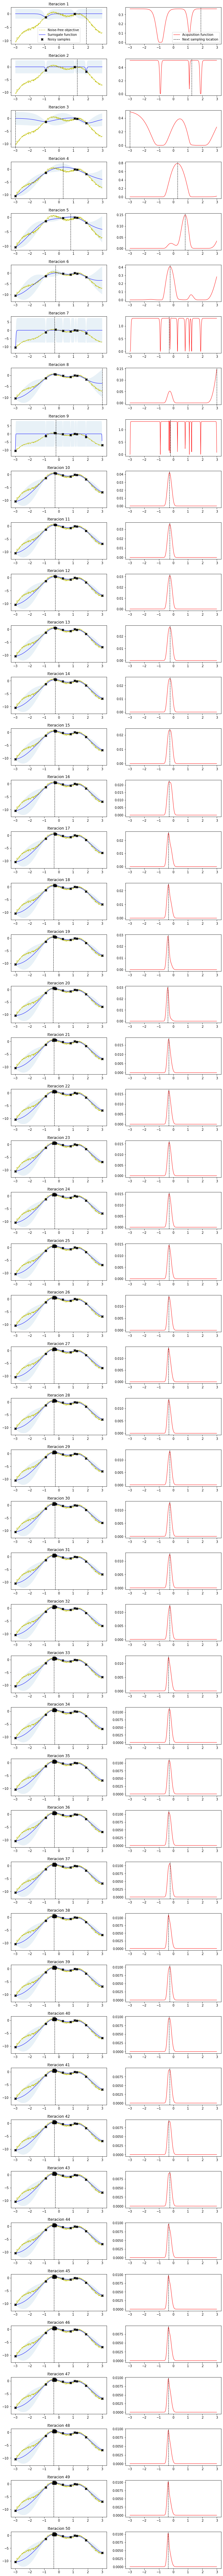

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition

# Proceso Gaussiano con nucleo Matérn
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=ruido**2)

# Iniciamos variables:
X_ejemplo = X_init
Y_ejemplo = Y_init

# Numero de iteraciones:
n_iter = 50

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Actualizar el proceso gaussiano:
    gpr.fit(X_ejemplo, Y_ejemplo)

    # Siguiente punto:
    X_siguiente = proponer_localizacion(mejora_esperada,
                                   X_ejemplo, Y_ejemplo, gpr, limites)
    
    Y_siguiente = f(X_siguiente, ruido)
    
    # Mostrar las funciones:
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_ejemplo, Y_ejemplo,
                       X_siguiente, show_legend=i==0)
    plt.title(f'Iteracion {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, mejora_esperada(X, X_ejemplo, Y_ejemplo, gpr),
                     X_siguiente, show_legend=i==0)
    
    # Añadimos ejemplos:
    X_ejemplo = np.vstack((X_ejemplo, X_siguiente))
    Y_ejemplo = np.vstack((Y_ejemplo, Y_siguiente))

Podemos hacer ahora predicciones para valores que no estaban en el grupo de los ejemplos:

In [ ]:
gpr.predict([[0.2]])

array([[-0.16993167]])

In [ ]:
f(np.array([0.2]), ruido=0.2)

array([-0.49969034])

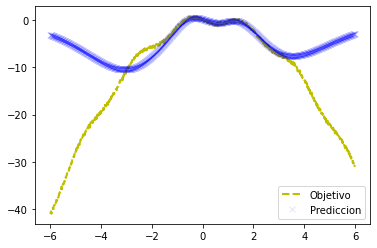

In [ ]:
# Funcion objetivo con y sin ruido:
limites = np.array([[-6, 6]])
X = np.arange(limites[:, 0], limites[:, 1], 0.01).reshape(-1, 1)
Y = f(X)
plt.plot(X, Y, 'y--', lw=2, label='Objetivo')
plt.plot(X, gpr.predict(X), 'bx', lw=1, alpha=0.1, label='Prediccion')
plt.legend();

¿A que valores esta intentado devolver el modelo las regiones mas alejadas de los ejemplos de entrenamiento?

Respuesta: